In [1]:
from PIL import Image
import torch
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
!curl -o ImageNetLables.json https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
!gdown 1XV9mJUnq3J09qYgVajwHMqQmvZ4U9Q0T --folder -O ./pictures

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14209  100 14209    0     0  21892      0 --:--:-- --:--:-- --:--:-- 21893
Retrieving folder contents
Processing file 17K2kO4CnIh_XtnOjJ0rqZMhk9lK0r_s4 p1.jpg
Processing file 1FSgbGPXJKkumYxu4F9Gd97abfOJX2llY p2.jpg
Processing file 1x5HsBG0SSw7UwG6w1JhqFTu9Aj85zSwi p3.jpg
Processing file 188a_7XVtKap0HPgyvdfqhe8HYh6B4Sna p4.jpg
Processing file 13VI3HqAZIhfG28Toriuqsn9w980W2F39 p5.jpg
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=17K2kO4CnIh_XtnOjJ0rqZMhk9lK0r_s4
To: /home/arch/projects/college_assignments/EvolutionAlgorithm_CS410/FastGradientMethod/pictures/p1.jpg
100%|█████████████████████████████████████████| 135k/135k [00:00<00:00, 568kB/s]
Downloading...
From: https://drive.google.com/uc?id=1FSgbGPXJKkumYxu4F9Gd97

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
MSSV=21522188

In [5]:

def compute_gradient(func, inp, **kwargs):
    inp.requires_grad = True
    loss = func(inp, **kwargs)
    loss.backward()
    inp.requires_grad = False
    return inp.grad.data


def read_image(path, device=device):
    img = Image.open(path).convert('RGB')
    transform = Compose([
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tensor = transform(img).unsqueeze(0).to(device)
    return tensor


def to_array(tensor):
    tensor = tensor.squeeze()
    unnormalize_transform = Compose([
        Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
    ])
    tensor = unnormalize_transform(tensor)
    array = tensor.permute(1, 2, 0).cpu().detach().numpy()
    return array


def scale_grad(grad):
    grad = torch.abs(grad).mean(dim=1).detach().permute(1, 2, 0)
    grad /= grad.quantile(0.98)
    grad = torch.clamp(grad, 0, 1)
    return grad.numpy()


In [6]:
def func(inp, net=None, target=None):
    out = net(inp)
    target_tensor = torch.LongTensor([target]).to(inp.device)
    
    loss = torch.nn.functional.cross_entropy(out, target_tensor)
    return loss

def attack(tensor, net, eps=1e-3, n_iter=50):
    original_prediction = net(tensor).argmax().item()
    new_tensor = tensor.clone()
    
    for i in range(n_iter):
        net.zero_grad()
        grad = compute_gradient(func, new_tensor, net=net, target=original_prediction)
        new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
        new_prediction = net(new_tensor).argmax().item()
        
        if original_prediction != new_prediction:
            break
    
    return new_tensor, original_prediction, new_prediction


In [7]:
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
model.eval()
model = model.to(device)

In [8]:
import json
labels_path = 'ImageNetLables.json' 
with open(labels_path) as f:
    Lables = json.load(f)

In [9]:
Lables

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'water snake',
 'vin

In [10]:
from PIL import Image
import torch
import os
from torchvision import transforms
import matplotlib.pyplot as plt

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
def predict_image_class(image_path):
   
    img = Image.open(image_path).convert('RGB')
    img_t = preprocess(img).unsqueeze(0).to(device)
    
    
    with torch.no_grad():
        outputs = model(img_t)
        _, predicted_idx = outputs.max(1)
        predicted_class = Lables[predicted_idx]

    
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

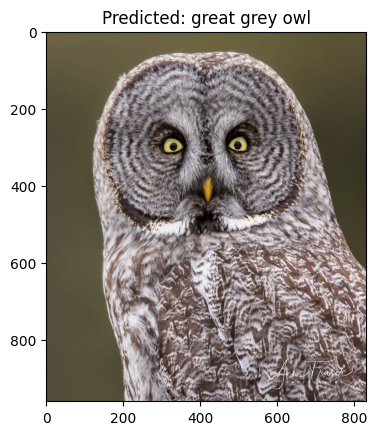

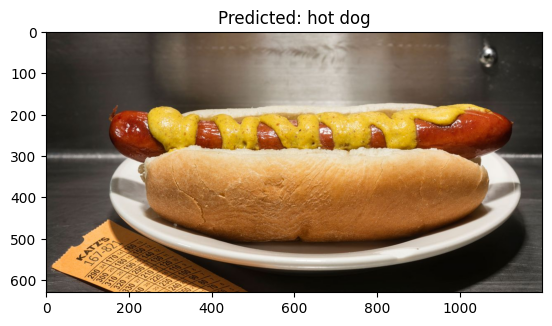

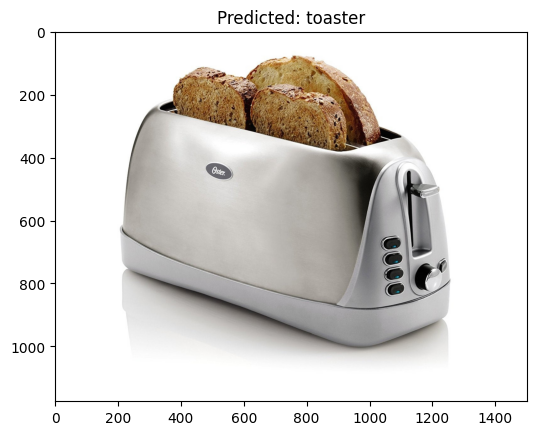

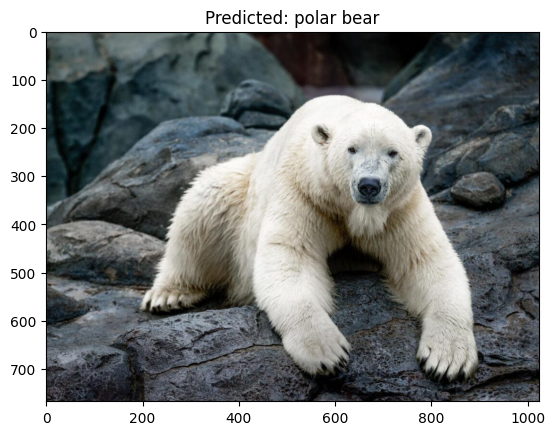

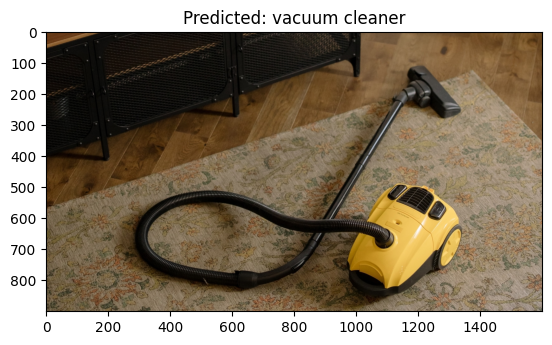

In [11]:
import os

dir = "pictures"
for filename in tqdm(os.listdir(dir)):
    if filename.lower().endswith('.jpg'):  
        image_path = os.path.join(dir, filename)
        predict_image_class(image_path)

# FGSM Attack

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


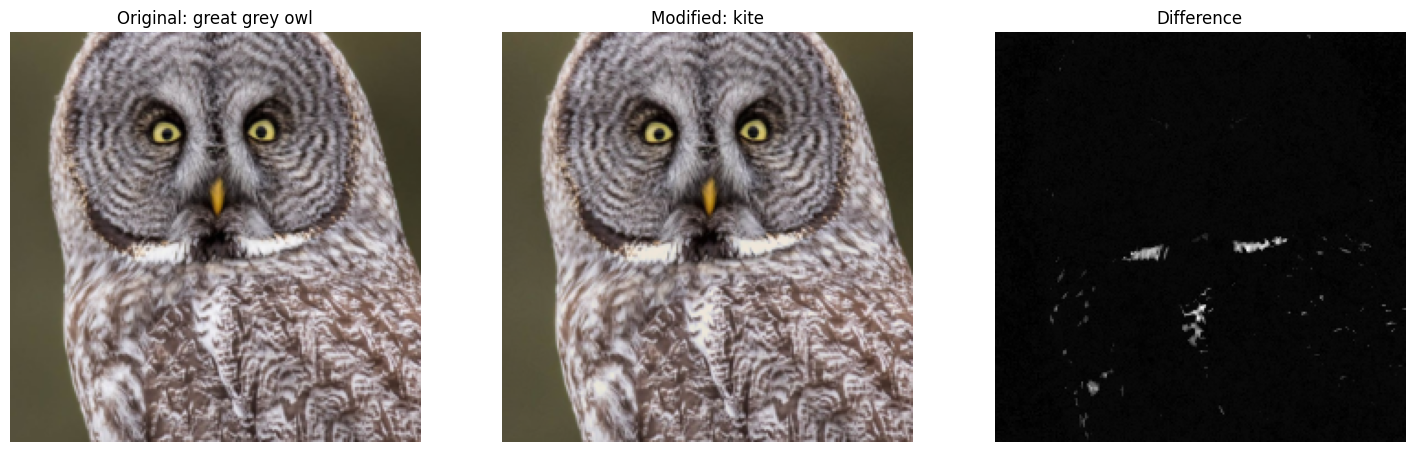

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


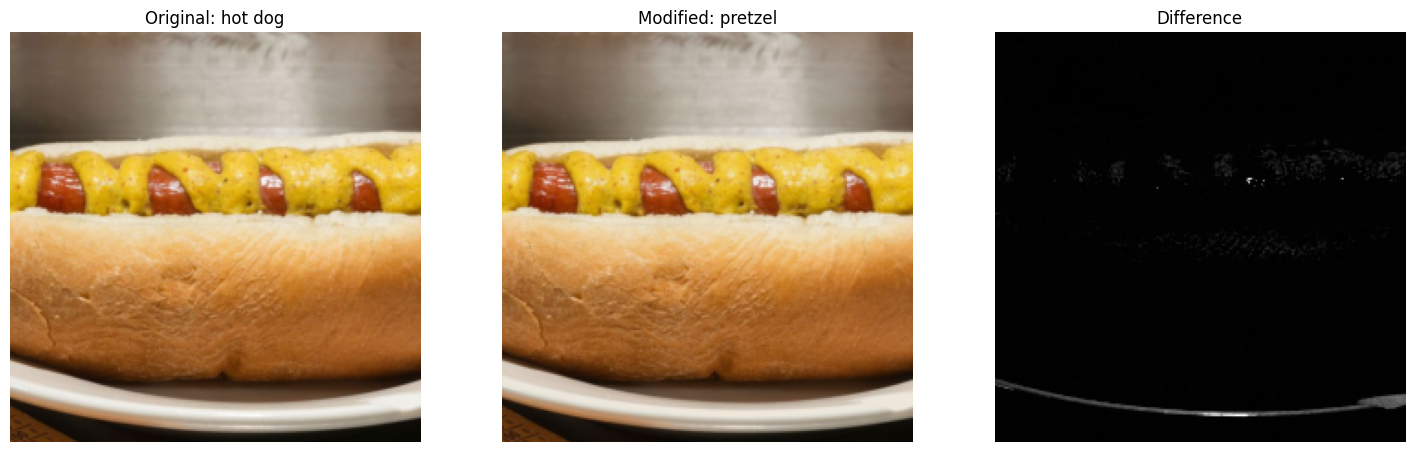

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


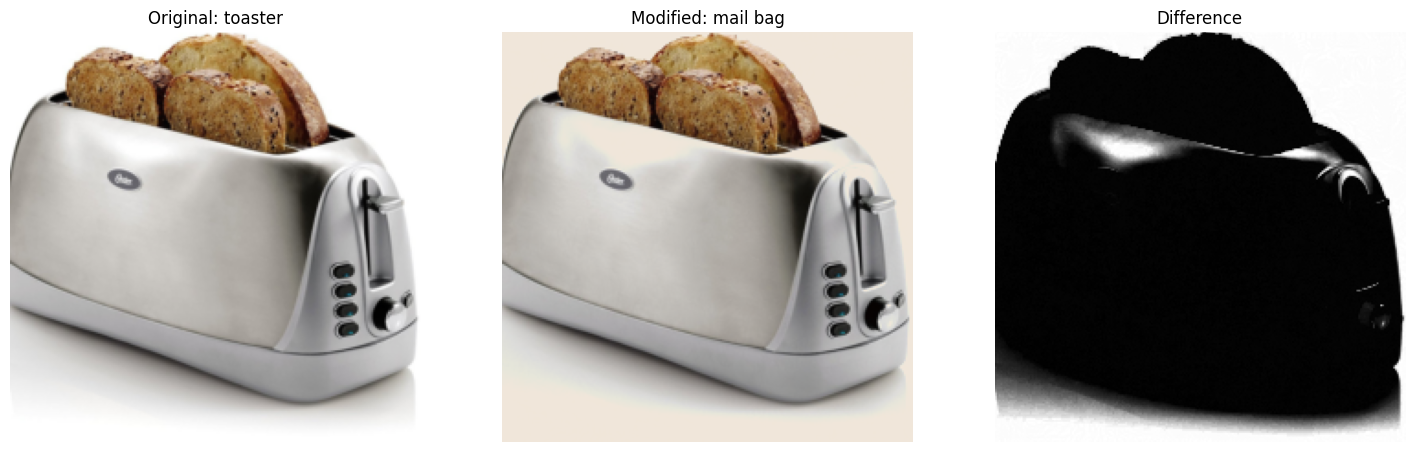

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


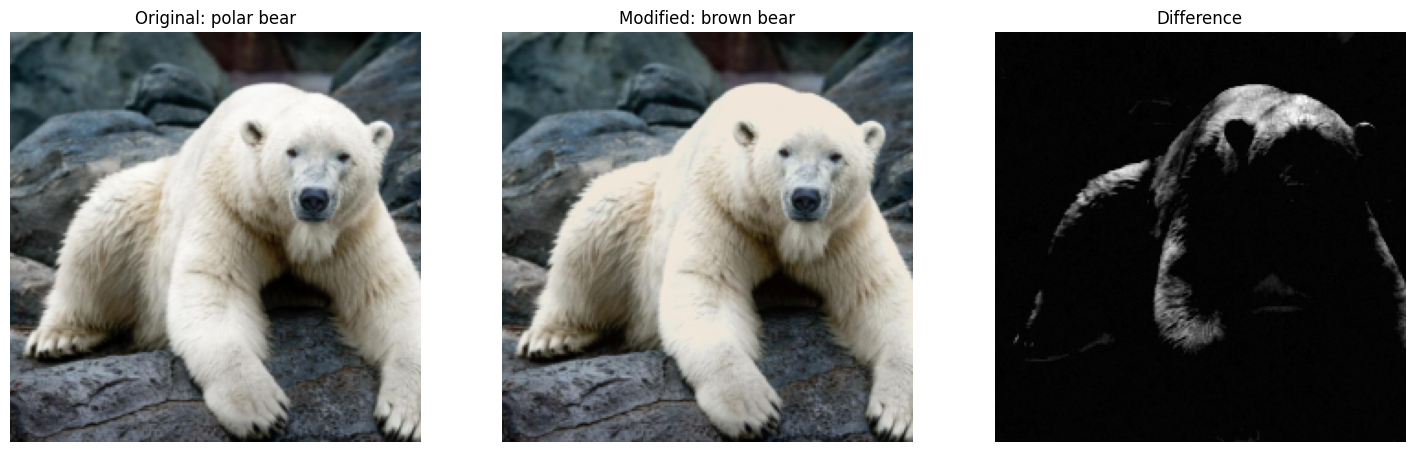

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


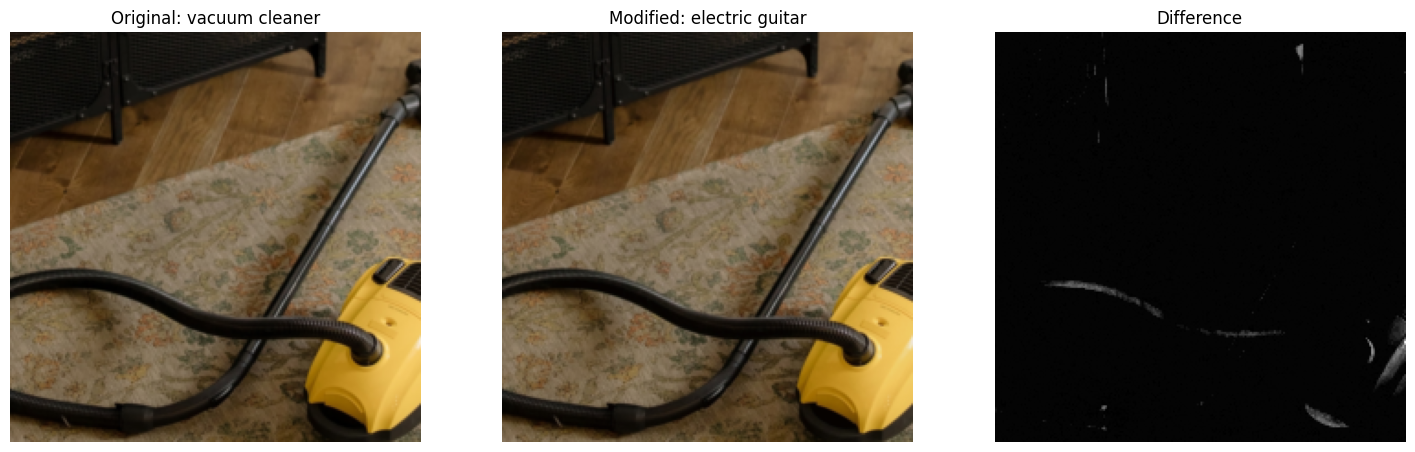

In [12]:
for filename in tqdm(os.listdir(dir)):
        if filename.lower().endswith('.jpg'):  
            image_path = os.path.join(dir, filename)
            
        tensor = read_image(image_path)
        new_tensor, orig_prediction, new_prediction = attack(tensor, model, eps=1e-3, n_iter=100)
    
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(to_array(tensor))
        plt.title(f"Original: {Lables[orig_prediction]}")  
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(to_array(new_tensor))
        plt.title(f"Modified: {Lables[new_prediction]}")  
        plt.axis('off')

        plt.subplot(1, 3, 3)
        difference = np.abs(to_array(tensor) - to_array(new_tensor))
        plt.imshow(difference.mean(axis=-1), cmap='gray')
        plt.title("Difference")
        plt.axis('off')

        plt.show()